**Author**: Justine Debelius (justine.debelius@ki.se)<br>
**Date**: Summer/Fall 2021<br>
**Conda enviroment**: `micc-2021.11`<br>
**Python version**: 3.6.10<br>
**Python packages**: `pystan` (v. 2.19); `patsy` (0.5.1); <br>
**QIIME 2 version**: 2020.6<br>
**QIIME 2 plugins**: `gemeilli` (v. 0.0.7); `deicode` (v. 0.2.4)'; `empress` (v 1.1.0.dev); `songbird` (v. 1.0.4)<br>


This notebook will take the per-subject paired CTF coordinates and compare the tissue types (normal and tumor) between the two types. It ultimately produces figure 1 for the manuscript, along with the corresponding table of features and representative sequences.

In [1]:
import itertools as it
import os
import pickle

import biom
from matplotlib import rcParams
import matplotlib.pyplot as plt
# import matplotlib_venn
import numpy as np
import pandas as pd
import openpyxl
import patsy
import scipy
import skbio
import statsmodels.api as sms
import statsmodels.formula.api as smf
import statsmodels.graphics as smg
import seaborn as sn

from qiime2 import Artifact, Metadata, Visualization

import qiime2.plugins.diversity.actions as q2_diversity
import qiime2.plugins.emperor.actions as q2_emperor
import qiime2.plugins.feature_table.actions as q2_feature_table
import qiime2.plugins.gemelli.actions as q2_gemelli

import scripts.tax_colors as tax_colors

rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
# rcParams['pdf.fonttype'] = 42
np.set_printoptions(precision=5)

%matplotlib inline

# Data Loading

In [2]:
meta_q2 = Metadata.load('data/metadata_paired.tsv')
meta = meta_q2.to_dataframe()
meta['long_survival'] = meta['long_survival'].astype(int)

In [3]:
subject_meta = meta.groupby('host_subject_id').first()

In [4]:
table_q2 = Artifact.load('data/tables/phylum_defined_table.qza')

In [ ]:
taxa_q2 = Artifact.load('data/tables/taxonomy.qza')
taxa = taxa_q2.view(pd.Series).apply(lambda x: pd.Series(x.split(';')))
taxa = taxa.loc[list(table_q2.view(biom.Table).ids(axis='observation'))]
taxa.loc[taxa[[2, 4]].isin(['c__Clostridia', 'f__Family_XI']).all(axis=1), 4] = \
             'f__Clostridia_Family_XI'
taxa.loc[taxa[[2, 4]].isin(['c__Bacilli', 'f__Family_XI']).all(axis=1), 4] = \
             'f__Bacilli_Family_XI'
taxa_meta = Metadata(taxa.rename(columns={0: 'kingdom', 1: 'phylum', 2: 'class', 3: 'order',
                                          4: 'family', 5: 'genus', 6: 'species'}))


# CTF

In [ ]:
state_subject_ordination = Artifact.load('data/diversity/ctf/state_subject_ordination.qza')
state_feature_ordination = Artifact.load('data/diversity/ctf/state_feature_ordination.qza')
subject_biplot = Artifact.load('data/diversity/ctf/subject_biplot.qza')

# Difference between tissue types in CTF space

In [ ]:
# state_subject_ordination = Artifact.load('data/diversity/ctf/state_subject_ordination.qza')
state_subject_diff = state_subject_ordination.view(pd.DataFrame).copy()
state_subject_diff['PC2'] = state_subject_diff['PC2']  * -1
state_subject_diff.sort_values(['subject_id', 'tissue_num'], inplace=True, 
                               ascending=True)
state_subject_diff = \
    state_subject_diff.groupby('subject_id')[['PC1', 'PC2', 'PC3']].diff().dropna()
state_subject_diff['long_survival'] = \
    meta.loc[state_subject_diff.index, 'long_survival']

In [ ]:
state_subject_diff.sort_values(['PC2']).tail(10)

,PC1,PC2,PC3,long_survival
#SampleID,,,,
1106,-0.024377,0.919721,0.753835,1
1084,-0.029940,0.919777,1.586439,0
1062,-0.008349,0.971716,0.866586,0
1178,-0.017458,0.992071,0.765476,1
1082,0.025474,1.002142,0.654947,0
1090,-0.015946,1.003224,1.455847,0
1172,0.008158,1.008697,0.992526,1
1144,-0.008584,1.015683,0.390029,1
1052,-0.020515,1.054175,0.916453,0


In [ ]:
feature_diffs = state_feature_ordination.view(pd.DataFrame)
feature_diffs['PC2'] = feature_diffs['PC2'] * -1
feature_diffs.sort_values(['feature_id', 'tissue_num'], ascending=True, inplace=True)
feature_diffs.set_index('feature_id', inplace=True)
feature_diffs = \
    feature_diffs.groupby('feature_id')[['PC1', 'PC2', 'PC3']].diff().dropna()

In [ ]:
tissue_coords_wide =  state_subject_ordination.view(pd.DataFrame).pivot_table(
    index='subject_id', columns='tissue_num', values=['PC1', 'PC2', 'PC3']
)
tissue_coords_wide['PC1'] = tissue_coords_wide['PC1'] * -1
tissue_coords_wide['PC2'] = tissue_coords_wide['PC2'] * -1
tissue_coords_wide[('PC1', 'diff')] = tissue_coords_wide['PC1'].diff(axis=1)[1]
tissue_coords_wide[('PC2', 'diff')] = tissue_coords_wide['PC2'].diff(axis=1)[1]
tissue_coords_wide[('PC3', 'diff')] = tissue_coords_wide['PC3'].diff(axis=1)[1]
tissue_coords_wide[("PC23", 'radius')] = \
    np.sqrt(np.square(tissue_coords_wide[[('PC2', 'diff'), ("PC3", 'diff')]]).sum(axis=1))
tissue_coords_wide[('PC23', 'theta')] = (
     np.arctan(tissue_coords_wide[("PC3", 'diff')] / tissue_coords_wide[("PC2", 'diff')]) + 
     np.pi * (tissue_coords_wide[("PC2", 'diff')] < 0)
     )
tissue_coords_wide.sort_index(axis='columns', inplace=True)

In [ ]:
tissue_coords_wide[('PC23', 'theta')].describe()

count    101.000000
mean       1.124329
std        0.386566
min       -0.709561
25%        0.984240
50%        1.179328
75%        1.368682
max        1.752886
Name: (PC23, theta), dtype: float64

In [ ]:
def permutative_paired_t_test(x1, x2, nperm=999):
    """
    """
    ref_ = x1 - x2
    x_perm = np.vstack([np.random.permutation(x2) for i in np.arange(nperm)])
    x_ref = np.vstack([x1] * nperm)
    test_diff = x_ref - x_perm
    t_raw, p_raw = scipy.stats.ttest_1samp(ref_, 0)
    sign = np.sign(t_raw)
    test_stat = np.array([scipy.stats.ttest_1samp(x, 0) for x in test_diff])
    
    
    p_iter = ((test_stat[:, 0] * sign > t_raw * sign).sum() + 1) / (nperm + 1)
    
    d = (x1 - x2).mean() / (x1 - x2).std()
    
    return sign, t_raw, p_iter, np.absolute(d)
permutative_paired_t_test(tissue_coords_wide['PC1'][1].copy().values, 
                          tissue_coords_wide['PC1'][0].copy().values,
                          )


(1.0, 5.4216633086332, 0.001, 0.54216633086332)

In [ ]:
permutative_paired_t_test(tissue_coords_wide['PC2'][1].copy().values, 
                          tissue_coords_wide['PC2'][0].copy().values,
                          )

(1.0, 16.142153140887412, 0.001, 1.6142153140887414)

In [ ]:
permutative_paired_t_test(tissue_coords_wide['PC3'][1].copy().values, 
                          tissue_coords_wide['PC3'][0].copy().values,
                          )

(1.0, 22.683213722818767, 0.001, 2.2683213722818762)

In [ ]:
state_subject_diff.sort_values(['PC2']).tail(10)

,PC1,PC2,PC3,long_survival
#SampleID,,,,
1106,-0.024377,0.919721,0.753835,1
1084,-0.029940,0.919777,1.586439,0
1062,-0.008349,0.971716,0.866586,0
1178,-0.017458,0.992071,0.765476,1
1082,0.025474,1.002142,0.654947,0
1090,-0.015946,1.003224,1.455847,0
1172,0.008158,1.008697,0.992526,1
1144,-0.008584,1.015683,0.390029,1
1052,-0.020515,1.054175,0.916453,0


# DR

For differential abundance, we're using a songbird-inspired differential abundance test.

I had a really good discussion with Jamie Morton, who shared his ferret repository and his code for a LME model with Pystan. After some rocky discussion, we came to the conclusion that I can use the LME to look at the tumor tissue. So, I think that's the approach that I'm going to use. The idea is that we the individual becomes the random intercept (allowing for a paired sample) and then I think we ask what the difference is in a given taxon based on individual exposure. I'm not sure if I need to factor tissue type into the model (probably), so that's maybe a consideration.

This rank-based method also requires a reference group. I want to define a group that I think has suffecient power to handle as those sequences which are present with a relative abundance of at least 1/2500 in at least 10% of the total samples. The remaining sequences will be collapsed into an "other" group, which I hope to use as a reference. That gives us a somewhat denser matrix with counts.

Stan is ridiculously computationally expensive, and the work was done in hte 07-Stan.ipynb notebook.

In [21]:
table_q2 = Artifact.load('data/tables/phylum_defined_table.qza')          
table = table_q2.view(pd.DataFrame)
# feat_filt = table.columns[(table.T / table.sum(axis=1) > 1/1000).sum(axis=1) > 20]
# table = table[feat_filt].copy()
table.shape

(202, 7045)

In [22]:
tissue_rank = pd.read_csv('data/differential_ranking/tissue_num_1000.tsv', sep='\t')
tissue_rank.set_index('feature-id', inplace=True)
tissue_rank = tissue_rank.loc[tissue_rank.index.isin(table_q2.view(pd.DataFrame).columns)]
tissue_rank['tissue_rank'] = 1
tissue_rank['tissue_rank'] = tissue_rank['tissue_rank'].cumsum() - 1

In [23]:
tissue_rank.shape

(243, 3)

In [24]:
table_pres = (table > 0) * 1
hi_feat = (table_pres[tissue_rank.index].cumsum(axis=1) > 0).sum(axis=0)
hi_feat = (~hi_feat.duplicated(keep='first')) | (hi_feat < 202)
hi_feat = hi_feat.index[hi_feat].values

lo_feat = (table_pres[tissue_rank.index[::-1]].cumsum(axis=1) > 0).sum(axis=0)
lo_feat =  (~lo_feat.duplicated(keep='first')) | (lo_feat < 202)
lo_feat = lo_feat[lo_feat].index.values

In [25]:
taxa.loc[hi_feat].groupby([3, 4, 5], sort=True)[6].count()

3                     4                         5                             
o__Bacteroidales      f__Bacteroidaceae         g__Bacteroides                    3
                      f__Prevotellaceae         g__Paraprevotella                 1
                      f__Rikenellaceae          g__Alistipes                      1
o__Bifidobacteriales  f__Bifidobacteriaceae     g__Bifidobacterium                1
o__Clostridiales      f__Clostridiaceae_1       g__Clostridium_sensu_stricto_1    1
                      f__Lachnospiraceae        f__Lachnospiraceae                2
                                                g__Anaerostipes                   1
                                                g__Blautia                        2
                                                g__Marvinbryantia                 1
                      f__Peptostreptococcaceae  g__Peptostreptococcus             1
                      f__Ruminococcaceae        f__Ruminococcaceae               

In [26]:
taxa.loc[lo_feat].groupby([3, 4, 5], sort=True)[6].count()

3                     4                      5                         
o__Bacteroidales      f__Bacteroidaceae      g__Bacteroides                1
                      f__Porphyromonadaceae  g__Parabacteroides            1
                                             g__Porphyromonas              1
o__Burkholderiales    f__Alcaligenaceae      g__Parasutterella             1
                                             g__Sutterella                 1
                      f__Oxalobacteraceae    g__Massilia                   1
o__Campylobacterales  f__Campylobacteraceae  g__Campylobacter              1
o__Clostridiales      f__Lachnospiraceae     g__Hungatella                 2
                                             g__Lachnoclostridium          1
                      f__Ruminococcaceae     g__Ruminococcaceae_UCG-014    1
o__Fusobacteriales    f__Fusobacteriaceae    g__Fusobacterium              3
o__Lactobacillales    f__Carnobacteriaceae   g__Granulicatella             1
    

In [27]:
tissue_rank['tissue_group'] = \
    tissue_rank.index.to_frame()['feature-id'].isin(hi_feat) * 1 + \
    tissue_rank.index.to_frame()['feature-id'].isin(lo_feat) * -1

In [28]:
tissue_rank['family'] = taxa[4]
tissue_rank['color_group'] = tissue_rank['family'].apply(
    lambda x: tax_colors.remappings.get(x, 'Other')).replace(
        tax_colors.mapped_colors)

In [29]:
meta['dr_alr'] = np.log2(
    table[hi_feat].sum(axis=1) / table[lo_feat].sum(axis=1)
)

In [30]:
taxa2 = taxa.drop(columns=[0, 6]).loc[tissue_rank.index].copy()
taxa2[2] = taxa2[2].apply(lambda x: f'c__uncl_{x}' if 'p__' in x else x)
taxa2[3] = taxa2[3].apply(lambda x: f'o__uncl_{x}' if (('p__' in x) | ('c__' in x)) else x)
taxa2[4] = taxa2[4].apply(lambda x: f'f__uncl_{x}' if (('p__' in x) | ('c__' in x) | ('o__' in x)) else x)
taxa2[5] = taxa2[5].apply(lambda x: f'g__uncl_{x}' if (('p__' in x) | ('c__' in x) | ('o__' in x) | ('f__' in x)) else x)

taxa2[4] = taxa2.apply(lambda x: '{4} ({3})'.format(*x.values) if ('Family' in x) else x[4], axis=1)

taxa2['taxonomy'] = taxa2.apply(lambda x: '; '.join(x.values).replace("__", '. ').replace("_", ' '), axis=1)

tissue_rank['taxonomy'] = taxa2['taxonomy']

In [31]:
tissue_rank['prevelance'] = pres_table.mean(axis=0)
tissue_rank.sort_values('tissue_rank', ascending=True, inplace=True)
tissue_rank.loc[tissue_rank['tissue_group'] == 1, 'cum_prevelance'] = \
    pres_table[tissue_rank.index[tissue_rank['tissue_group'] == 1]].cummax(axis=1).mean(axis=0)
tissue_rank.sort_values('tissue_rank', ascending=False, inplace=True)
tissue_rank.loc[tissue_rank['tissue_group'] == -1, 'cum_prevelance'] = \
    pres_table[tissue_rank.index[tissue_rank['tissue_group'] == -1]].cummax(axis=1).mean(axis=0)

In [32]:
tissue_rank

,tissue_mean,tissue_std,tissue_rank,tissue_group,family,color_group,taxonomy,prevelance,cum_prevelance
feature-id,,,,,,,,,
Fuso-e47b7c5,2.826611,0.804647,242,-1,f__Fusobacteriaceae,#97CE2F,p. Fusobacteria; c. Fusobacteriia; o. Fusobact...,0.252475,0.252475
Camp-5b14d87,2.094515,0.447911,241,-1,f__Campylobacteraceae,#C17754,p. Proteobacteria; c. Epsilonproteobacteria; o...,0.272277,0.465347
Fuso-d2f4ba7,1.805172,0.757661,240,-1,f__Fusobacteriaceae,#97CE2F,p. Fusobacteria; c. Fusobacteriia; o. Fusobact...,0.123762,0.500000
Hung-78c2b8e,1.512501,0.573203,239,-1,f__Lachnospiraceae,#7D3560,p. Firmicutes; c. Clostridia; o. Clostridiales...,0.336634,0.618812
Fuso-7fa9543,1.475031,0.635509,238,-1,f__Fusobacteriaceae,#97CE2F,p. Fusobacteria; c. Fusobacteriia; o. Fusobact...,0.212871,0.668317
...,...,...,...,...,...,...,...,...,...
Bact-47d7490,-1.115434,0.544573,4,1,f__Bacteroidaceae,#616161,p. Bacteroidetes; c. Bacteroidia; o. Bacteroid...,0.188119,0.732673
Marv-c55b486,-1.222974,0.406353,3,1,f__Lachnospiraceae,#7D3560,p. Firmicutes; c. Clostridia; o. Clostridiales...,0.361386,0.688119
Bact-7ce20dc,-1.376615,0.674825,2,1,f__Bacteroidaceae,#616161,p. Bacteroidetes; c. Bacteroidia; o. Bacteroid...,0.198020,0.500000


In [33]:
table_s3 = tissue_rank[['tissue_group', 'tissue_rank', 'prevelance', 'cum_prevelance', 'taxonomy']].copy()
!mkdir -p output/tables
table_s3.to_csv('output/tables/table_s3.tsv', sep='\t')

In [36]:
alrs = pd.DataFrame({
    'alr4': np.log2(table_q2.view(pd.DataFrame)[lo_feat].sum(axis=1) / 
                    table_q2.view(pd.DataFrame)[hi_feat].sum(axis=1)),
})
alrs['subject_id'] = meta['host_subject_id']
alrs['tissue'] = meta['tissue_num']

alrs.sort_values(['subject_id', 'tissue'], ascending=True, inplace=True)
d_alrs = alrs.groupby('subject_id', sort=False).diff().dropna()

In [37]:
dr_fit = smf.mixedlm('alr4 ~ tissue', data=alrs, groups=alrs['subject_id']).fit()
print(dr_fit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: alr4     
No. Observations: 202     Method:             REML     
No. Groups:       101     Scale:              1.5189   
Min. group size:  2       Log-Likelihood:     -435.6015
Max. group size:  2       Converged:          Yes      
Mean group size:  2.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -2.101    0.263 -7.973 0.000 -2.617 -1.584
tissue        1.781    0.173 10.270 0.000  1.441  2.121
Group Var     5.492    1.015                           



In [38]:
dr_fit.pvalues

Intercept    1.553688e-15
tissue       9.605285e-25
Group Var    1.119799e-05
dtype: float64

In [53]:
rep_seqs = Artifact.load('data/tables/phylum_defined_rep_seqs.qza').view(pd.Series)
rep_seqs_dr = pd.concat(axis=0, objs=[
    rep_seqs[lo_feat].add_prefix('>').add_suffix('_tissue-dr-alr_tumor'),
    rep_seqs[hi_feat].add_prefix('>').add_suffix('_tissue-dr-alr_normal')
]).astype(str)


In [55]:
os.makedirs('output/seqs', exist_ok=True)
rep_seqs_dr.to_csv('output/seqs/file_s1_tissue_alr_sequences.fasta', sep='\n', header=None)

# Figure

In [39]:
color_order = [
    pd.Series(['f__Lachnospiraceae', 'f__Ruminococcaceae', 'c__Clostridia', 'c__Bacilli', 'p__Firmicutes']), # Firmictutes
    pd.Series(['f__Bacteroidaceae', 'f__Rikenellaceae', 'f__Porphyromonadaceae', 'f__Prevotellaceae', 'p__Bacteroidetes']),
    pd.Series(['f__Fusobacteriaceae', 'c__Gammaproteobacteria', 'f__Campylobacteraceae', 'p__Proteobacteria']), # Proteobacteria
    pd.Series([ 'f__Bifidobacteriaceae', 'f__Verrucomicrobiaceae', 'f__Synergistaceae', 'Other']),
]
proteo = ['c__Gammaproteobacteria', 'f__Campylobacteraceae', 'p__Proteobacteria']
phyla = ['Firmicutes', 'Bacteriodetes', ['Fusobacterium', 'Proeobacteria'], 'Other']

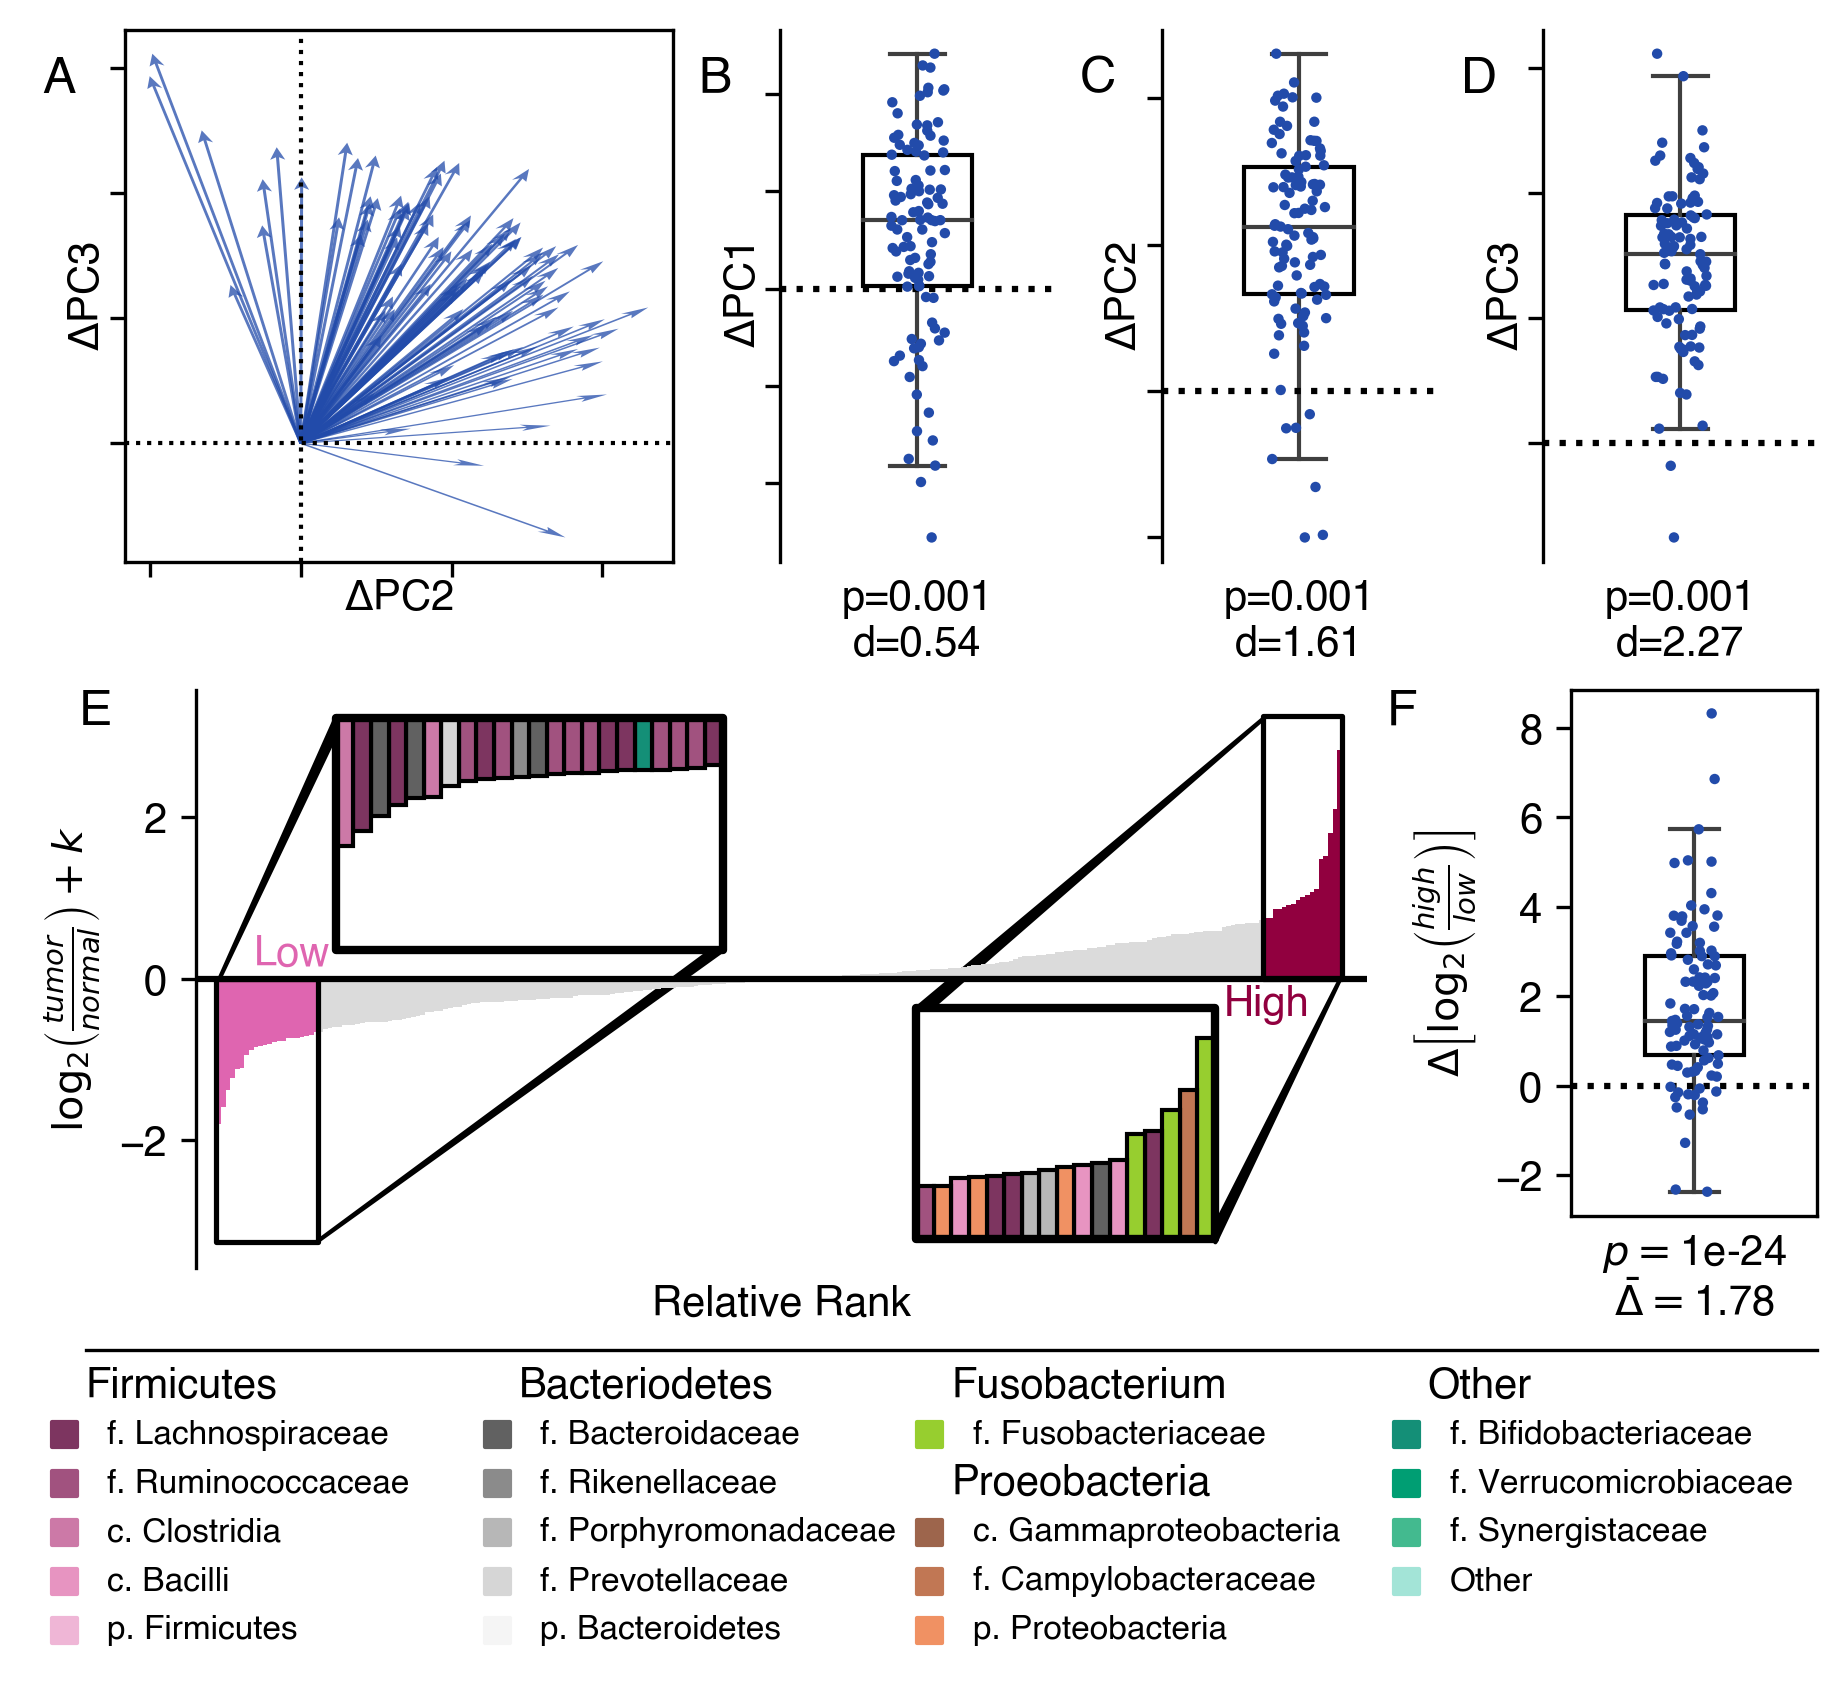

In [44]:
fig = plt.figure(
    dpi=300,
    constrained_layout=True,
    facecolor='None',
    figsize=(6, 5.5)
)
fig_hi, fig_lo, fig_leg = fig.subfigures(3, 1, height_ratios=[0.4, 0.4, 0.2], hspace=0)
gs_hi = fig_hi.add_gridspec(1, 5)

for i, pc in enumerate(['PC1', 'PC2', 'PC3']):
    ax = fig_hi.add_subplot(gs_hi[0, i + 2])
    sn.boxplot(
        x=np.array([0] * 101),
        y=tissue_coords_wide[pc].diff(axis=1)[1],
        linewidth=1,
        fliersize=0,
        width=0.4,
        boxprops={'edgecolor': 'k', 'facecolor':'w'},
        # palette=['w'],
        ax=ax,
    )
    sn.stripplot(
        x=np.array([0] * 101),
        y=tissue_coords_wide[pc].diff(axis=1)[1],
        edgecolor='None',
        palette=['#224baa'],
        marker='.',
        s=5,
#         alpha=0.75,
        ax=ax,
    )
    ax.plot(ax.get_xlim(), [0, 0], 'k:')
    ax.set_ylabel(f"$\Delta${pc}")
    ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
    sn.despine(ax=ax, bottom=True, top=True, right=True, trim=False)
#     if i == 0:
#         ax.set_yticklabels(ax.get_yticks() * 1e3)
#         ax.set_ylabel(' '.join([f"$\Delta$({pc})",'(x $10^{-3}$)']))
    ax.yaxis.set_tick_params(labelleft=False)
    fit_ax = smf.mixedlm(
        f'PC{i+1} ~ tissue_num', 
        data=state_subject_ordination.view(pd.DataFrame),
        groups=state_subject_ordination.view(pd.DataFrame)['subject_id'],
        ).fit()
    ax.set_xlabel(
        'p={2:1.3f}\nd={3:1.2f}'.format(
            *permutative_paired_t_test(tissue_coords_wide[pc][1].copy().values,
                                       tissue_coords_wide[pc][0].copy().values))
    )
    ax.text((ax.get_xlim()[0] - 0.3 * np.absolute(np.diff(ax.get_xlim()))),
            (ax.get_ylim()[1] - 0.05 * np.absolute(np.diff(ax.get_ylim()))),
            list('BCD')[i], 
             size=12, 
             ha='left', 
             va='top')
    
ax_ord3 = fig_hi.add_subplot(gs_hi[0, 0:2])
ax_ord3.scatter(state_subject_diff['PC1'],
                 state_subject_diff['PC3'], 
                 s=0,
                 )
for _, [pc1, pc2] in state_subject_diff[['PC2', 'PC3']].iterrows():
    ax_ord3.arrow(x=0, dx=pc1, 
                  y=0, dy=pc2, 
                  length_includes_head=True,
#                   facecolor=sn.color_palette()[0], 
                  facecolor='#224baa',
                  width=0.01,
                  head_width=0.05,
                  head_length=0.1,
                  overhang=0.2,
                  edgecolor='None',
#                   linewidth=5,
                  alpha=0.75,
                  )
ax_ord3.set_ylabel('$\Delta\left ( \right )')
ax_ord3.set_xlabel('$\Delta$PC2')
ax_ord3.set_ylabel('$\Delta$PC3')

ax_ord3.set_xticks(fig.axes[1].get_yticks())
ax_ord3.set_yticks(fig.axes[2].get_yticks())
ax_ord3.set_xlim(fig.axes[1].get_ylim())
ax_ord3.set_ylim(fig.axes[2].get_ylim())


ax_ord3.xaxis.set_tick_params(labelbottom=False)
ax_ord3.yaxis.set_tick_params(labelbottom=False)


ord3_xlim = ax_ord3.get_xlim()
ord3_ylim = ax_ord3.get_ylim()

ax_ord3.plot(ord3_xlim, [0, 0], 'k:', linewidth=1)
ax_ord3.plot([0, 0], ord3_ylim, 'k:', linewidth=1)


ax_ord3.set_xlim(fig.axes[1].get_ylim())
ax_ord3.set_ylim(fig.axes[2].get_ylim())
ax_ord3.text(ax_ord3.get_xlim()[0] - np.diff(ax_ord3.get_xlim()) * 0.15,
             ax_ord3.get_ylim()[1] - np.diff(ax_ord3.get_ylim()) * 0.05,
             'A', size=12, ha='left', va='top'
             )

fig_lo_l, fig_lo_r = fig_lo.subfigures(1, 2, wspace=0, width_ratios=[3/4, 1/4])

### ALR Boxplot
ax_dr_bp = fig_lo_r.add_subplot(1,1,1)
sn.boxplot(
    x=np.array([0] * 101),
    y=d_alrs[f'alr4'],
    linewidth=1,
    fliersize=0,
    width=0.4,
    # palette=['w'],
    ax=ax_dr_bp,
    boxprops={'edgecolor': 'k', 'facecolor':'w'},
    )
sn.stripplot(
    x=np.array([0] * 101),
    y=d_alrs[f'alr4'],
    edgecolor='None',
    palette=['#224baa'],
    marker='.',
    s=5,
    ax=ax_dr_bp,
    )
xlim = ax_dr_bp.get_xlim()
ax_dr_bp.set_xlim(xlim)
ax_dr_bp.plot(xlim, [0, 0], 'k:')
ax_dr_bp.xaxis.set_tick_params(bottom=False, labelbottom=False)
ax_dr_bp.set_ylabel('$\\Delta \\left [ \\log_{2} \\left ( \\frac{high}{low} \\right ) \\right ]$')
ax_dr_bp.set_xlabel(''.join(['$p=$', '{1:1.1g}'.format(*dr_fit.pvalues.values),
                             '\n$\\bar{\Delta}=$', '{1:1.2f}'.format(*dr_fit.params.values),
                             ]))
ax_dr_bp.text(-1.25, ax_dr_bp.get_ylim()[1], 'F', size=12, ha='left', va='top')

### Ranks
straight_ranks = tissue_rank.copy()
gs_lo = fig_lo_l.add_gridspec(7, 5)
dr_rank_ax = fig_lo_l.add_subplot(gs_lo[:, :])
dr_rank_ax.bar(x=straight_ranks['tissue_rank'],
       height=straight_ranks['tissue_mean'],
       width=1,
       color=straight_ranks['tissue_group'].replace({-1: '#91003f', 0: '#dbdbdb', 1: '#df65b0'})
       )
dr_rank_ax.plot([-5, len(straight_ranks) + 5], [0, 0], 'k-')
dr_rank_ax.set_xlim([-5, len(straight_ranks) + 5])
dr_rank_ax.set_xlabel('Relative Rank')
dr_rank_ax.set_ylabel('$\\log_{2} \\left ( \\frac{tumor}{normal} \\right )  + k  $')


top = np.ceil(np.absolute(straight_ranks['tissue_mean']).max() * 1.1 * 4) / 4
dr_rank_ax.fill_between([-0.5, (straight_ranks['tissue_group'] == 1).sum() - 0.5],
                         0, -top, 
                        zorder=2, facecolor='None', edgecolor='k', 
                        linewidth=1.25)
dr_rank_ax.fill_between(
    len(straight_ranks) - 0.5 - np.array([0, (straight_ranks['tissue_group'] == -1).sum()]),
    0, top, 
    zorder=2, facecolor='None', edgecolor='k', linewidth=1.25
)
ylim = dr_rank_ax.get_ylim()
ylim = np.array([-1, 1]) * np.absolute(ylim).max()

ydelta = ylim[1]
dr_rank_ax.set_ylim(ylim)
dr_rank_ax.text(len(straight_ranks) - 7.5, -0.075, 'High', ha='right', va='top', color='#91003f',)
dr_rank_ax.text(7.5, 0.05, 'Low', ha='left', va='bottom', color='#df65b0')
dr_rank_ax.xaxis.set_tick_params(labelbottom=False, bottom=False)

xdelta = np.diff(dr_rank_ax.get_xlim())[0]


low_rank = straight_ranks.loc[straight_ranks['tissue_group'] == 1, 
                              'tissue_rank']
low_mean = straight_ranks.loc[straight_ranks['tissue_group'] == 1, 
                              'tissue_mean']
low_colors = straight_ranks.loc[straight_ranks['tissue_group'] == 1, 'color_group']

dr_rank_ax.fill_between(
    x=(np.array([low_rank.min(), low_rank.max() + 1]) * 0.015 + 0.1) * xdelta,
    y1=ydelta * 0.1, 
    y2=ydelta * 0.9,
    facecolor='None',
    edgecolor='k',
    linewidth=2,
)
dr_rank_ax.bar(
    x=(low_rank + 0.49) * 0.015 * xdelta + xdelta * 0.1,
    bottom=ydelta * 0.9,
    height = 0.8 * ydelta * (low_mean / top),
    width=xdelta * 0.015,
    edgecolor='k',
    color=low_colors,
    zorder=0,
)
dr_rank_ax.fill_between(
    x=[0, (low_rank.min() * 0.015 + 0.1) * xdelta],
    y1=[0, ydelta*0.85], y2=[0, ydelta*0.91],
    color='k',
)
dr_rank_ax.fill_betweenx(
    x1=[low_rank.max(), ((low_rank.max() + 1) * 0.015 + 0.1) * xdelta], 
    x2=[low_rank.max(), ((low_rank.max() + 1) * 0.015 + 0.09) * xdelta],
    y=[-top, ydelta*0.10], 
    color='k',
    zorder=0,
)

hi_rank = straight_ranks.loc[straight_ranks['tissue_group'] == -1, 
                              'tissue_rank']
hi_mean = straight_ranks.loc[straight_ranks['tissue_group'] == -1, 
                              'tissue_mean']
hi_colors = straight_ranks.loc[straight_ranks['tissue_group'] == -1,
                               'color_group']

sub_rank = hi_rank.max() - np.array([hi_rank.min() - 1, hi_rank.max()])
dr_rank_ax.fill_between(
    x=(sub_rank * -1 * 0.015 + 0.85) * xdelta,
    y1=-ydelta * 0.1, 
    y2=-ydelta * 0.9,
    facecolor='None',
    edgecolor='k',
    linewidth=2,
)
dr_rank_ax.fill_between(
    x=[hi_rank.max(), (sub_rank.min() * -1 * 0.015 + 0.85) * xdelta],
    y1=[0, -ydelta*0.85], y2=[0, -ydelta*0.91],
    color='k',
)
dr_rank_ax.fill_betweenx(
    x1=[hi_rank.min(), ((sub_rank * -1 * 0.015 + 0.85) * xdelta).min()],
    x2=[hi_rank.min(), ((sub_rank * -1 * 0.015 + 0.8625) * xdelta).min()],
    y=[top, -ydelta*0.10], 
    color='k',
    zorder=0,
)

dr_rank_ax.bar(
    x=(0.85 - (hi_rank.max() - hi_rank + 0.49) * 0.015) * xdelta,
    bottom=ydelta * -0.9,
    height=0.8 * ydelta / top * hi_mean,
    width=xdelta * 0.015,
    edgecolor='k',
    color=hi_colors,
    zorder=0,
)

sn.despine(ax=dr_rank_ax, top=True, bottom=True, right=True, trim=False)
dr_rank_ax.text(dr_rank_ax.get_xlim()[0] - np.diff(dr_rank_ax.get_xlim()) * 0.1,
                dr_rank_ax.get_ylim()[1],
                'E', 
                size=12, ha='left', va='top')

ax_leg = fig_leg.add_subplot(1,1,1)
ax_leg.set_ylim(-0.5, 5.75)
ax_leg.set_xlim(-0.1, 4)

for x, (phylum, families) in enumerate(zip(*(phyla, color_order))):
    x = x + (x > 2) * 0.1
    if isinstance(phylum, str):
        ax_leg.text(x, 5, phylum, ha='left', va='center')
    else:
        for y, phy in enumerate(phylum):
            ax_leg.text(x, 5 - 2*y, phy, ha='left', va='center')
    y1 = 4 - families.index.to_frame()[0] + families.isin(proteo) * -1
    colors = [tax_colors.mapped_colors[fam] for fam in families]
    ax_leg.scatter(x-0.05 * np.ones(y1.shape), y1, c=colors, marker='s')
    for y, fam in zip(*(y1, families.values)):
        ax_leg.text(x+0.05, y, fam.replace("__", '. '), size=8, ha='left', va='center')
sn.despine(ax=ax_leg, left=True, right=True, bottom=True, top=False, trim=True)
ax_leg.xaxis.set_tick_params(left=False, labelleft=False, right=False, labelright=False, length=0)
ax_leg.yaxis.set_tick_params(top=False, labeltop=False, length=0, bottom=False, labelbottom=False)

fig.savefig('output/figures/figure_1_tissue_diff.pdf')
fig.savefig('output/figures/figure_1_tissue_diff.png')

**Figure 1. There is a difference in the microbiome between tumor and normal tissues**.
A global pattern separating tumor and normal tissue can be seen in CTF ordination space. (A) When the change between normal and tumor tissue is centered, there are clear directional changes. Arrows connect from normal tissue to tumor tissue at the tip. The difference between normal and tumor tissue can also be see along individual components: (B) PC 1, (C) PC2, and (D) PC 3. Ticks along PC 2 (B) and PC 3 (D) match the two-dimensional axes in (A). All boxplots are shown with a Cohen’s d effect size statistic for a one-sided t-test and p-values from a permutative one sample t-test, 999 permutations. We looked for features separating normal and tumor tissue using a differential ranking technique that accounted for individual identity. (E) The relative rank of abundant features based on the magnitude of change. Light pink (“low” or normal tissue associated) and dark pink (“high” or tumor associated) were selected for the additive log ratio calculation (ALR). Insets in (E) show family level taxonomic identify of the selected features. Legend gives taxonomic assignment based on color. (F) The change in the ALR between normal and tumor tissue. Coefficient from linear mixed effect model comparing the change based on tissue type; p < 1x10-12.